# Pedometer Design Program

Following code below loads the parameter of filters and constant variables

In [31]:
# Constant Variable of Program
SAMPLING_RATE = 20
NUM_AUTOCORR_LAGS = 200
AUTOCORR_MIN_HALF_LEN = 3
AUTOCORR_DELTA_AMPLITUDE_THRESH = 5e8

# these need to determined using test data
deriv_coeffs = [-6, 31, 0, -31, 6]
lpf_coeffs = [-5, 6, 34, 68, 84, 68, 34, 5, -5]

## 1) Import Data of Accelerometer from csv file

The algorithm works with acceleration magnitude, need to convert (x, y, z) acceleration into magnitude values.

Num Steps: 32.0


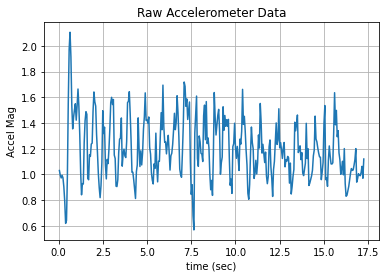

In [27]:
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("data/walking/trail2.csv")
time = data.iloc[:, 0].values
accelx = data.iloc[:, 1].values
accely = data.iloc[:, 2].values
accelz = data.iloc[:, 3].values
steps = data.iloc[:, 5].values[0]
print("Num Steps: " + str(steps))

# the theroetical max sampling time of the MPU is 1kHz
mag = []
for i, x in enumerate(accelx):
    mag.append(math.sqrt((accelx[i]**2)+(accely[i]**2)+(accelz[i]**2)))

plt.plot(time, mag)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Raw Accelerometer Data")
plt.grid()
plt.show()

## 2) Apply Low Pass Filter to Data

The parameters of the low pass filter need to calibrated for our accelometer. It should remove high frequency noise from the acceleration signals. Using FIR style filter for easier implementation, the parameter of FIR filter can be determine used Matlab Tools or Scipy python tools.

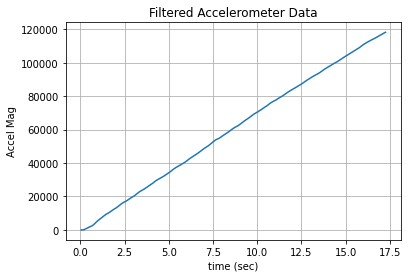

In [28]:
lpf = [];
temp_lpf = 0.0;
for i, m in enumerate(mag):
    for j, f in enumerate(lpf_coeffs):
        if i-j >= 0:
            temp_lpf += float(f*mag[i-j])
    lpf.append(temp_lpf)

plt.plot(time, lpf)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Filtered Accelerometer Data")
plt.grid()
plt.show()

## 3) Remove Mean 

This removes the DC offset of signal, this can be done using Gussian Filter, Mean Filter or Low pass filter.

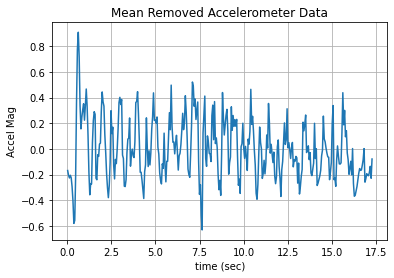

In [29]:
mean = 0 
for i, m in enumerate(mag):
    mean += m
mean = mean / len(mag)
for i, m in enumerate(mag):
    mag[i] = mag[i] - mean

plt.plot(time, mag)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Mean Removed Accelerometer Data")
plt.grid()
plt.show()

# 4) Autocorrelation

Autocorelation convolves signal with original signal delay to extract the peaks.

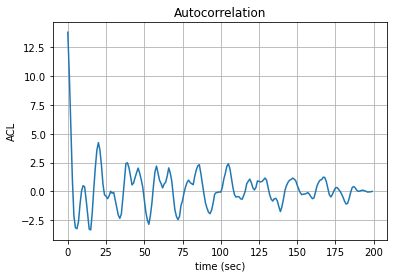

In [32]:
autocorr_buff = [] 
for lag in range(NUM_AUTOCORR_LAGS):
    temp_autocorr = 0.0
    for i in range(NUM_AUTOCORR_LAGS - lag):
        temp_autocorr += mag[i] * mag[i + lag]
    autocorr_buff.append(temp_autocorr)

t = []
for i in range(NUM_AUTOCORR_LAGS):
    t.append(i)
    
plt.plot(t, autocorr_buff)
plt.xlabel("time (sec)")
plt.ylabel("ACL")
plt.title("Autocorrelation")
plt.grid()
plt.show()

#    for (int lag = 0; lag < NUM_AUTOCORR_LAGS; lag++){
#        int temp_autocorr = 0;
#        for (int i = 0; i < NUM_AUTOCORR_LAGS - lag; i++){
#            temp_autocorr += lpf[i] * lpf[i+lag];
#        }
#        autocorr_buff[lag] = temp_autocorr;
#    }

## 5) FIR Deriative filter

The derivative filter is used to calculate points of peaks. As the peaks represent zeros and roots when discrete derivative is taken. The derivative filter need to be calibrated for our particular setup.

In [ ]:
int deriv[NUM_AUTOCORR_LAGS] = {};
    for (int lag = 0; lag < NUM_AUTOCORR_LAGS; lag++){
        int temp_deriv = 0;
        for (int i = 0; i < PEDOMETER_SAMPLES; i++){
            if (lag-i >= 0){
                temp_deriv += deriv_coeffs[i] * autocorr_buff[lag-i];
            }
        }
        deriv[lag] = temp_deriv;
    }

## 6) Determine index of Peaks

The following algorithm looks for peaks, by searching for zeros from out of derivative filter.

In [ ]:
int peak_idx = 0;
    for (int lag = 0; lag < NUM_AUTOCORR_LAGS; lag++){
        if ((deriv[lag] > 0) && (deriv[lag-1] >0) && (deriv[lag-2] < 0) && (deriv[lag-3])){
            peak_idx = lag - 1;
            break;
        }
    }
    
    int loop_limit = 0;
    if ((autocorr_buff[peak_idx] > autocorr_buff[peak_idx-1]) && (autocorr_buff[peak_idx] > autocorr_buff[peak_idx+1])) {
        //peak_ind is perfectly set at the peak. nothing to do
    }
    else if ((autocorr_buff[peak_idx] > autocorr_buff[peak_idx+1]) && (autocorr_buff[peak_idx] < autocorr_buff[peak_idx-1])) {
        //peak is to the left. keep moving in that direction
        loop_limit = 0;
        while ((autocorr_buff[peak_idx] > autocorr_buff[peak_idx+1]) && (autocorr_buff[peak_idx] < autocorr_buff[peak_idx-1]) && (loop_limit < 10)) {
            peak_idx = peak_idx - 1;
            loop_limit++;
        }
    }
    else {
        //peak is to the right. keep moving in that direction
        loop_limit = 0;
        while ((autocorr_buff[peak_idx] > autocorr_buff[peak_idx-1]) && (autocorr_buff[peak_idx] < autocorr_buff[peak_idx+1]) && (loop_limit < 10)) {
            peak_idx = peak_idx + 1;
            loop_limit++;
        }
    }

## 7) Calculate Statistics on Autocorrection of Peak to Determine if Signal is Noise or Walking

Using signal stats determine of walking or noise.

In [ ]:
int neg_slope_count = 0;
    int delta_amplitude_right = 0;
    int pos_slope_count = 0;
    int delta_amplitude_left = 0;
    # first look to the right of the peak. walk forward until the slope begins decreasing
    int neg_slope_ind = peak_idx;
    int loop_limit_stats = NUM_AUTOCORR_LAGS-1;

    while ((autocorr_buff[neg_slope_ind+1] - autocorr_buff[neg_slope_ind] < 0) && (neg_slope_ind < loop_limit_stats)) {
        neg_slope_count = neg_slope_count + 1;
        neg_slope_ind = neg_slope_ind + 1;
    }
    
    //get the delta amplitude between peak and right trough
    delta_amplitude_right = autocorr_buff[peak_idx] - autocorr_buff[neg_slope_ind];
    
    //next look to the left of the peak. walk backward until the slope begins increasing
    int pos_slope_ind = peak_idx;
    loop_limit_stats = 0;
    while ((autocorr_buff[pos_slope_ind] - autocorr_buff[pos_slope_ind-1] > 0) && (pos_slope_ind > loop_limit_stats)) {
        pos_slope_count = pos_slope_count + 1;
        pos_slope_ind = pos_slope_ind - 1;
    }
    
    //get the delta amplitude between the peak and the left trough
    delta_amplitude_left = autocorr_buff[peak_idx] - autocorr_buff[pos_slope_ind];
    



## 8) Use stats to determine peaks are valid

If peaks are valid calculate number of steps using the Sampling rate, the window length and number valid peaks.

In [ ]:
int num_steps = 0;
if ((pos_slope_count > AUTOCORR_MIN_HALF_LEN) && (neg_slope_count > AUTOCORR_MIN_HALF_LEN) && (delta_amplitude_right > AUTOCORR_DELTA_AMPLITUDE_THRESH) && (delta_amplitude_left > AUTOCORR_DELTA_AMPLITUDE_THRESH)) {
        //the period is peak_ind/sampling_rate seconds. that corresponds to a frequency of 1/period
        //with the frequency known, and the number of seconds is 4 seconds, you can then find out the number of steps
        num_steps = (SAMPLING_RATE*WINDOW_LENGTH)/peak_idx;
    } else {
        //not a valid autocorrelation peak
        num_steps = 0;
    }

    return num_steps;

### Reference for Pedometer Algorithm

[1] https://github.com/nerajbobra/embedded_pedometer

[2] https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/p3225-morris.pdf
